state sent to choose action (0, 0)
state sent to choose action after tupling(0, 0)
Physical Action for Agent 0 from problem solver: 2
state sent to choose action (9, 0)
state sent to choose action after tupling(9, 0)
Physical Action for Agent 1 from problem solver: 4
state sent to choose action (0, 1)
state sent to choose action after tupling(0, 1)
Physical Action for Agent 0 from problem solver: 4
state sent to choose action (9, 0)
state sent to choose action after tupling(9, 0)
Physical Action for Agent 1 from problem solver: 3
state sent to choose action (1, 1)
state sent to choose action after tupling(1, 1)
Physical Action for Agent 0 from problem solver: 2
state sent to choose action (8, 0)
state sent to choose action after tupling(8, 0)
Physical Action for Agent 1 from problem solver: 1
state sent to choose action (1, 2)
state sent to choose action after tupling(1, 2)
Physical Action for Agent 0 from problem solver: 4
state sent to choose action (8, 0)
state sent to choose action

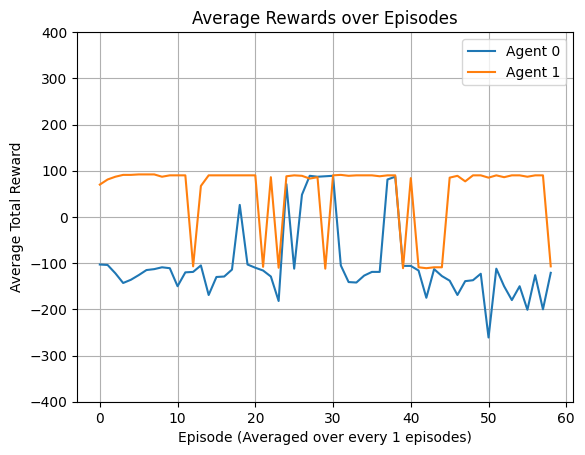

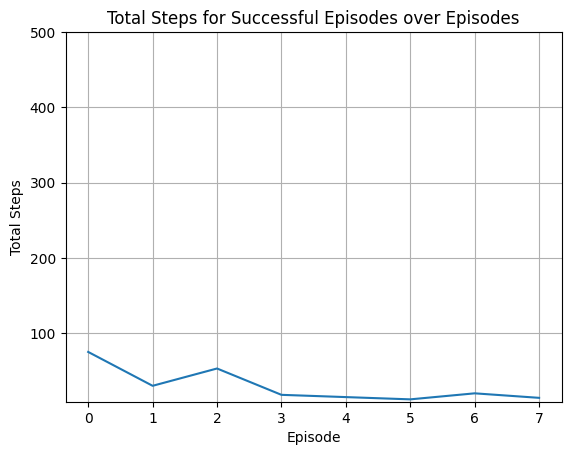

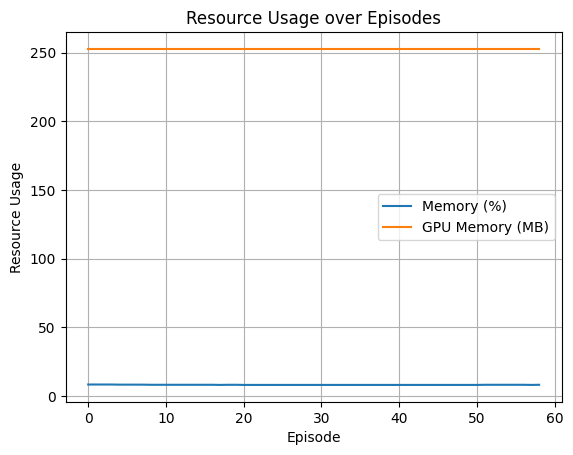

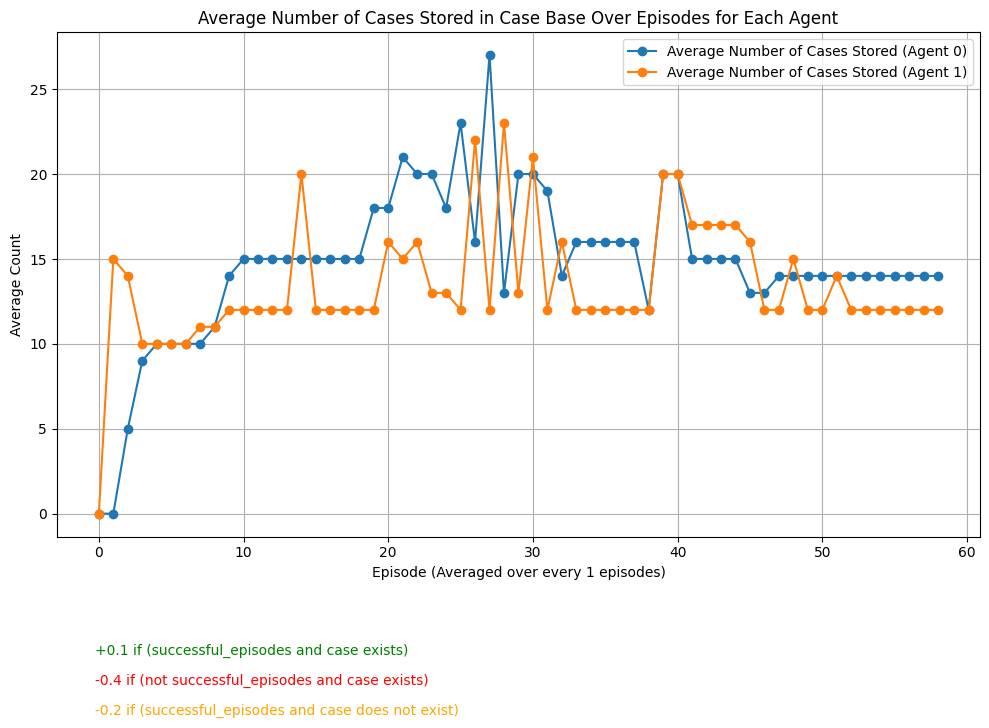

In [1]:
import numpy as np
import random
from collections import defaultdict
import ast
import json
import psutil
import pynvml
import matplotlib.pyplot as plt
import csv
import os
from datetime import datetime

from environment_ma_sensory_vector_dynamic import Env

class ProblemSolver:
    def __init__(self, num_actions, env, alpha, gamma, epsilon):
        self.env = env
        self.num_actions = num_actions
        self.learning_rate = alpha
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.q_tables = [defaultdict(lambda: [0.0] * num_actions) for _ in range(env.num_agents)]

    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)

    def choose_action(self, agent_idx, state):
        print(f"state sent to choose action {state}")
        state = tuple(state)
        print(f"state sent to choose action after tupling{state}")
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            state_action = self.q_tables[agent_idx][state]
            action = self.arg_max(state_action)
        return action

    def learn(self, agent_idx, state, action, reward, next_state, case_base=None):
        state = tuple(state)
        next_state = tuple(next_state)
        current_q = self.q_tables[agent_idx][state][action]
        max_next_q = max(self.q_tables[agent_idx][next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_tables[agent_idx][state][action] = new_q


class Case:
    INCREMENT_SUCCESS = 0.1
    DECREMENT_UNSUCCESS = 0.2
    DECREMENT_SUCCESS_NO_CASE = 0.2
    DEL_THRESHOLD = 0.49

    def __init__(self, problem, solution, trust_value=0.5, total_time_steps=0):
        self.problem = ast.literal_eval(problem) if isinstance(problem, str) else problem
        self.solution = solution
        self.trust_value = trust_value
        self.total_time_steps = total_time_steps  # New attribute for total time steps

    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)
        state2 = np.atleast_1d(state2)
        CNDMaxDist = 6
        v = state1.size
        DistQ = np.sum([Case.dist_q(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def dist_q(X1, X2):
        return np.min(np.abs(X1 - X2))

    @staticmethod
    def retrieve(state, case_base, threshold=0.1):
        state = ast.literal_eval(state) if isinstance(state, str) else state
        for case in case_base:
            if state == case.problem: 
                return case

    @staticmethod
    def reuse(agent_idx, c, own_temp_case_base, comm_temp_case_base, source='own'):
        """Reuse step for adding cases to temporary case bases."""
        if source == 'own':
            own_temp_case_base.append(c)
        elif source == 'comm':
            comm_temp_case_base.append(c)

    @staticmethod
    def revise(agent_idx, case_base, temporary_case_base, successful_episodes, total_steps):
        for case in case_base:
            if any((case.problem, case.solution) == (temp_case.problem, temp_case.solution) for temp_case in temporary_case_base):
                if successful_episodes:
                    case.trust_value += Case.INCREMENT_SUCCESS
                else:
                    case.trust_value -= Case.DECREMENT_UNSUCCESS
            else:
                if successful_episodes:
                    case.trust_value -= Case.DECREMENT_SUCCESS_NO_CASE
            
            case.trust_value = max(0, min(case.trust_value, 1))
            print(f"case content after REVISE for agent {agent_idx}, problem: {case.problem}, solution: {case.solution}, tv: {case.trust_value}, time steps: {case.total_time_steps}")

    @staticmethod
    
    @staticmethod
    def retain(agent_idx, case_base, own_temp_case_base, comm_temp_case_base, successful_episodes, total_steps, threshold=DEL_THRESHOLD):
        if successful_episodes:
            for temp_case in reversed(own_temp_case_base):
                state = tuple(np.atleast_1d(temp_case.problem))

                existing_case = next((case for case in case_base if tuple(np.atleast_1d(case.problem)) == state), None)
                
                if existing_case is None:
                    case_base.append(temp_case)
                    print(f"Episode succeeded, case {temp_case.problem} is empty. Temporary case base stored to the case base: {temp_case.problem, temp_case.solution, temp_case.trust_value}")
                else:
                    if total_steps < existing_case.total_time_steps:
                        # Update the case in the case base if the new case has fewer total steps
                        existing_case.solution = temp_case.solution
                        existing_case.trust_value = max(0, temp_case.trust_value)
                        existing_case.total_time_steps = total_steps
                        print(f"Episode succeeded, updated case base with fewer steps: {temp_case.problem, temp_case.solution, temp_case.trust_value, total_steps}")
                    else:
                        print(f"Episode succeeded, case {temp_case.problem} for agent {agent_idx} is not updated as it has more or equal steps.")

        else:
            print(f"Episode not succeeded, temporary case base from own experience is not stored to the case base")

        case_base_dict = {tuple(np.atleast_1d(case.problem)): case for case in case_base}

        for temp_comm_case in reversed(comm_temp_case_base):
            state_comm = tuple(np.atleast_1d(temp_comm_case.problem))
            existing_case = case_base_dict.get(state_comm)

            if existing_case is None:
                case_base.append(temp_comm_case)
                case_base_dict[state_comm] = temp_comm_case
                print(f"Integrated case process. comm case {temp_comm_case.problem} is empty. Temporary case base stored to the case base: {temp_comm_case.problem, temp_comm_case.solution, temp_comm_case.trust_value}")
            else:
                print(f"Integrated case process. comm case {temp_comm_case.problem} for agent {agent_idx} is not empty. Temporary case base that not stored to the case base: {temp_comm_case.problem, temp_comm_case.solution, temp_comm_case.trust_value}")

        # Remove cases with trust values below the threshold
        case_base[:] = [case for case in case_base if case.trust_value >= threshold]

        for case in case_base:
            print(f"cases content after RETAIN, problem: {case.problem}, solution: {case.solution}, tv: {case.trust_value}, time steps: {case.total_time_steps}")

        return case_base

    

class QCBRL:
    def __init__(self, num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render):
        self.num_actions = num_actions
        self.env = env
        self.episodes = episodes
        self.max_steps = max_steps
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.render = render
        self.epsilon_decay = epsilon_decay  
        self.epsilon_min = epsilon_min  

        self.problem_solvers = [ProblemSolver(num_actions, self.env, alpha, gamma, epsilon) for _ in range(self.env.num_agents)]
        self.case_bases = [[] for _ in range(self.env.num_agents)]  # Individual case bases for each agent
        self.own_temp_case_bases = [[] for _ in range(self.env.num_agents)]  # Temporary case bases for own experiences
        self.comm_temp_case_bases = [[] for _ in range(self.env.num_agents)]  # Temporary case bases for communication experiences
        self.successful_episodes = [0] * self.env.num_agents
        self.rewards_per_episode = [[] for _ in range(self.env.num_agents)]  
        self.total_successful_episodes = 0 
        self.action_type = [0] * self.env.num_agents
        self.cases_per_episode = [[] for _ in range(self.env.num_agents)]

    def run(self):
        rewards = []
        memory_usage = []
        gpu_memory_usage = []
        num_successful_episodes = 0
        total_steps_list = []
        success_steps = []
        combined_data = []

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        for episode in range(self.episodes):
            states = self.env.reset()
            episode_reward = [0] * self.env.num_agents
            total_steps = 0 
            self.own_temp_case_bases = [[] for _ in range(self.env.num_agents)]
            self.comm_temp_case_bases = [[] for _ in range(self.env.num_agents)]
            success_count = [0] * self.env.num_agents
            dones = [False] * self.env.num_agents
            win_states = [False] * self.env.num_agents
            successful_episodes = False

            while not all(dones):
                actions = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    action = self.take_action(agent_idx, state)
                    actions.append(action)

                next_states, rewards, dones = self.env.step(actions)

                win_states = []
                for agent_idx in range(self.env.num_agents):
                    state = states[agent_idx]
                    action = actions[agent_idx]
                    reward = rewards[agent_idx]
                    next_state = next_states[agent_idx]

                    physical_state = tuple(state[0])
                    win_state = state[1]
                    comm_state = state[2]

                    physical_next_state = tuple(next_state[0])
                    win_next_state = next_state[1]
                    sensory_next_state = next_state[2]
                    comm_next_state = tuple(next_state[3]) if next_state[3] != 0 else next_state[3]

                    physical_action = action[0]
                    comm_action = action[1]
                    
                    if (comm_next_state == 0):
                        pass
                    else:
                        comm_case = Case(problem=comm_next_state[0], solution=comm_next_state[1], trust_value=comm_next_state[2], total_time_steps=comm_next_state[3])
                        Case.reuse(agent_idx, comm_case, self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], source='comm')

                    c = Case(physical_state, physical_action, total_time_steps=total_steps)
                    Case.reuse(agent_idx, c, self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], source='own')

                    if self.action_type[agent_idx] == 0:
                        self.problem_solvers[agent_idx].learn(agent_idx, physical_state, physical_action, reward, physical_next_state, self.case_bases[agent_idx])

                    if win_next_state: 
                        success_count[agent_idx] += 1

                    episode_reward[agent_idx] += reward
                    win_states.append(win_next_state)  

                states = next_states
                total_steps += 1

                if self.render:
                    self.env.render()

            if all(win_states):
                self.total_successful_episodes += 1
                success_steps.append(total_steps)
                successful_episodes = True

            for agent_idx in range(self.env.num_agents):
                self.rewards_per_episode[agent_idx].append(episode_reward[agent_idx])
                self.cases_per_episode[agent_idx].append(len(self.case_bases[agent_idx]))

                Case.revise(agent_idx, self.case_bases[agent_idx], self.own_temp_case_bases[agent_idx], win_states[agent_idx], total_steps=total_steps)
                self.case_bases[agent_idx] = Case.retain(agent_idx, self.case_bases[agent_idx], self.own_temp_case_bases[agent_idx], self.comm_temp_case_bases[agent_idx], win_states[agent_idx], total_steps=total_steps)

            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Collect combined data for this episode
            combined_row = [
                episode, Case.INCREMENT_SUCCESS, Case.DECREMENT_UNSUCCESS, Case.DECREMENT_SUCCESS_NO_CASE,
                *[len(self.case_bases[agent_idx]) for agent_idx in range(self.env.num_agents)],  # Total cases for each agent
                *[episode_reward[agent_idx] for agent_idx in range(self.env.num_agents)],  # Rewards for each agent
                total_steps, Case.DEL_THRESHOLD, int(successful_episodes)  # Total steps, deletion threshold, and episode success status
            ]
            combined_data.append(combined_row)

            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

        # Save combined data to CSV after all episodes
        self.save_combined_data_to_csv(combined_data)

        success_rate = self.total_successful_episodes / self.episodes * 100

        return self.rewards_per_episode, success_rate, memory_usage, gpu_memory_usage, success_steps, self.cases_per_episode


    def take_action(self, agent_idx, state):
        # print(f"state detected in take action function: {state}")
        physical_state = tuple(state[0])
        win_state = state[1]
        comm_state = state[2]
        # similar_solution = None

        # if np.random.rand() < 0.01:
        if np.random.rand() < self.epsilon:
        # if np.random.rand() < 0:
            # physical_action = np.random.choice(self.num_actions)
            # comm_action = 0

            physical_action = self.problem_solvers[agent_idx].choose_action(agent_idx, physical_state)
            comm_action = 0  # No communication action if using problem solver action
            self.action_type[agent_idx] = 0
            print(f"Physical Action for Agent {agent_idx} from problem solver: {physical_action}")

        else:
            similar_solution = Case.retrieve(physical_state, self.case_bases[agent_idx])
            if similar_solution is not None:
                physical_action = similar_solution.solution
                comm_action = (similar_solution.problem, similar_solution.solution, similar_solution.trust_value, similar_solution.total_time_steps)
                self.action_type[agent_idx] = 1
                # print(f"Problem detected as a similiar soulution in case base: {similar_solution.problem}")
                print(f"Physical Action for Agent {agent_idx} from case base: {physical_action}")
                # print(f"Communication Action for Agent {agent_idx} from case base: {comm_action}")
                # print(f"Trust value detected as a similiar solution in case base: {similar_solution.trust_value}")
            else:
                physical_action = self.problem_solvers[agent_idx].choose_action(agent_idx, physical_state)
                comm_action = 0  # No communication action if using problem solver action
                self.action_type[agent_idx] = 0
                print(f"Physical Action for Agent {agent_idx} from problem solver: {physical_action}")

        # print(f"physical action returned from the take action: {physical_action}")
        # print(f"comm action returned from the take action: {comm_action}")

        return (physical_action, comm_action)

    def case_exists_in_case_base(self, case, case_base):
        """Check if a case exists in the given case base."""
        return any(existing_case.problem == case.problem and existing_case.solution == case.solution for existing_case in case_base)
        
    
    def save_case_base_temporary(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_temporary_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": int(case.trust_value),
                            "total_time_steps": int(case.total_time_steps)} for case in self.own_temp_case_bases[agent_idx] + self.comm_temp_case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Temporary case base for Agent {agent_idx} saved successfully.")

    def save_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem, 
                            "solution": int(case.solution), 
                            "trust_value": int(case.trust_value),
                            "total_time_steps": int(case.total_time_steps)} for case in self.case_bases[agent_idx]]
            with open(filename, 'w') as file:
                json.dump(case_base_data, file)
            print(f"Case base for Agent {agent_idx} saved successfully.")
        
    def load_case_base(self):
        for agent_idx in range(self.env.num_agents):
            filename = f"cases/case_base_agent_{agent_idx}.json"
            try:
                with open(filename, 'r') as file:
                    case_base_data = json.load(file)
                    self.case_bases[agent_idx] = [Case(np.array(case["problem"]), case["solution"], case["trust_value"], case["total_time_steps"]) for case in case_base_data]
                    print(f"Case base for Agent {agent_idx} loaded successfully.")
            except FileNotFoundError:
                print(f"Case base file for Agent {agent_idx} not found. Starting with an empty case base.")

    def display_success_rate(self, success_rate):
        print(f"Success rate: {success_rate}%")


    @staticmethod
    def save_combined_data_to_csv(data):
        # Get the current date and time in the format 'YYYYMMDD_HHMMSS'
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Define root directory and create it if necessary
        root_folder = 'experiment_results/combination'
        os.makedirs(root_folder, exist_ok=True)

        # Create the full filename with the timestamp in the root folder
        filename = os.path.join(root_folder, f"combined_results_{timestamp}.csv")

        # Save combined data to CSV file
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            # Write header
            num_agents = (len(data[0]) - 7) // 2  # Calculate number of agents from the combined data length
            header = ['eps', 'inc_success', 'dec_unsuccess', 'dec_success_nocase'] + \
                    [f'total_case_agent_{agent_idx}' for agent_idx in range(num_agents)] + \
                    [f'rewards_agent_{agent_idx}' for agent_idx in range(num_agents)] + \
                    ['total_steps', 'del_threshold', 'eps_status']
            writer.writerow(header)

            # Write rows
            writer.writerows(data)

        print(f"Data saved to {filename}")



    
    # @staticmethod
    # def save_data_to_csv(data, filename_prefix):
    #     # Get the current date and time in the format 'YYYYMMDD_HHMMSS'
    #     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    #     # Define root directory and subdirectory paths
    #     root_folder = 'experiment_results'
    #     subfolders = {
    #         'avg_rewards': os.path.join(root_folder, 'avg_rewards'),
    #         'total_steps': os.path.join(root_folder, 'total_steps'),
    #         'avg_cases': os.path.join(root_folder, 'avg_cases')
    #     }

    #     # Create subfolder if it doesn't exist
    #     if filename_prefix in subfolders:
    #         os.makedirs(subfolders[filename_prefix], exist_ok=True)
    #         # Create the full filename with the timestamp in the appropriate subfolder
    #         filename = os.path.join(subfolders[filename_prefix], f"{filename_prefix}_{timestamp}.csv")
    #     else:
    #         raise ValueError("Invalid filename prefix. It must be one of 'avg_rewards', 'total_steps', or 'avg_cases'.")

    #     # Save data to CSV file
    #     with open(filename, 'w', newline='') as file:
    #         writer = csv.writer(file)
    #         # Write data to CSV file based on its format
    #         if filename_prefix == 'avg_rewards':
    #             # Write header
    #             header = ['eps'] + [f'agent_{i}_reward' for i in range(len(data))]
    #             writer.writerow(header)
    #             # Write rows
    #             for i in range(len(next(iter(data.values())))):  # Assuming all agents have equal length data
    #                 row = [i] + [data[f'Agent_{agent_idx}'][i] for agent_idx in range(len(data))]
    #                 writer.writerow(row)
    #         elif filename_prefix == 'total_steps':
    #             # Write header
    #             writer.writerow(['eps', 'total_steps'])
    #             # Write rows
    #             for i, total_steps in enumerate(data['total_steps']):
    #                 writer.writerow([i, total_steps])
    #         elif filename_prefix == 'avg_cases':
    #             # Write header with increment and decrement values
    #             header = ['inc_success', 'dec_unsuccess', 'dec_success_nocase', 'eps'] + [f'total_case_agent_{agent_idx}' for agent_idx in range(len(data))]
    #             writer.writerow(header)
    #             inc_success = Case.INCREMENT_SUCCESS
    #             dec_unsuccess = Case.DECREMENT_UNSUCCESS
    #             dec_success_nocase = Case.DECREMENT_SUCCESS_NO_CASE
    #             # Write rows
    #             for i in range(len(next(iter(data.values())))):  # Assuming all agents have equal length data
    #                 row = [inc_success, dec_unsuccess, dec_success_nocase, i] + [data[f'Agent_{agent_idx}'][i] for agent_idx in range(len(data))]
    #                 writer.writerow(row)

    #     print(f"Data saved to {filename}")

    def plot_rewards(self, rewards, window=1):
        avg_rewards = {}
        for agent_idx in range(self.env.num_agents):
            # Calculate the moving average of rewards over the specified window size
            moving_avg_rewards = [np.mean(rewards[agent_idx][i:i + window]) for i in range(0, len(rewards[agent_idx]), window)]
            avg_rewards[f'Agent_{agent_idx}'] = moving_avg_rewards
            
            # Plot the moving average rewards
            plt.plot(moving_avg_rewards, label=f'Agent {agent_idx}')

        # Save data to CSV with a unique timestamp
        # self.save_data_to_csv(avg_rewards, 'avg_rewards')

        plt.xlabel(f'Episode (Averaged over every {window} episodes)')
        plt.ylabel('Average Total Reward')
        plt.title('Average Rewards over Episodes')
        plt.legend()
        plt.ylim(-400, 400)
        plt.grid(True)
        plt.show()

    def plot_total_steps(self, total_steps_list):
        # total_steps_data = {'total_steps': total_steps_list}

        # Save data to CSV with a unique timestamp
        # self.save_data_to_csv(total_steps_data, 'total_steps')

        # Plot total steps for successful episodes
        plt.plot(total_steps_list)
        plt.xlabel('Episode')
        plt.ylabel('Total Steps')
        plt.title('Total Steps for Successful Episodes over Episodes')
        plt.ylim(top=500)
        plt.grid(True)
        plt.show()

    def plot_average_cases(self, num_cases_per_episode_agents, window=1):
        avg_num_cases_per_episode_agents = [
            [np.mean(num_cases_per_episode_agents[agent_idx][i:i + window]) for i in range(0, len(num_cases_per_episode_agents[agent_idx]), window)]
            for agent_idx in range(self.env.num_agents)
        ]

        # Prepare data for CSV
        avg_cases_data = {}
        for agent_idx in range(self.env.num_agents):
            avg_cases_data[f'Agent_{agent_idx}'] = avg_num_cases_per_episode_agents[agent_idx]

        # Save data to CSV with a unique timestamp
        # self.save_data_to_csv(avg_cases_data, 'avg_cases')

        # Plot the average number of cases stored in case base for each agent
        plt.figure(figsize=(10, 6))
        for agent_idx in range(self.env.num_agents):
            plt.plot(range(0, len(num_cases_per_episode_agents[agent_idx]), window), avg_num_cases_per_episode_agents[agent_idx], label=f'Average Number of Cases Stored (Agent {agent_idx})', marker='o')

        plt.xlabel(f'Episode (Averaged over every {window} episodes)')
        plt.ylabel('Average Count')
        plt.title('Average Number of Cases Stored in Case Base Over Episodes for Each Agent')
        plt.grid(True)
        plt.legend()

        # Adding the original incremental and decremental values as additional labels below the graph
        plt.figtext(0.1, -0.1, "+0.1 if (successful_episodes and case exists)", fontsize=10, color='green')
        plt.figtext(0.1, -0.15, "-0.4 if (not successful_episodes and case exists)", fontsize=10, color='red')
        plt.figtext(0.1, -0.2, "-0.2 if (successful_episodes and case does not exist)", fontsize=10, color='orange')

        plt.tight_layout()
        plt.show()

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    num_agents = 2
    num_obstacles = 10
    obstacles_random_steps = 20
    is_agent_silent = False
    episodes=59
    max_steps=400
    alpha=0.1
    gamma=0.9
    epsilon=0.1
    epsilon_decay = 0.995  
    epsilon_min = 0.01  
    render = True
    sensory_size = 0 #it must be odd, if event will be converted to one level odd number above
    gpixels=50
    gheight=10
    gwidth=10
    is_sensor_active = True
    window=1

    env = Env(num_agents=num_agents, num_obstacles=num_obstacles, obstacles_random_steps = obstacles_random_steps, is_agent_silent=is_agent_silent, sensory_size=sensory_size, gpixels=gpixels, gheight=gheight, gwidth=gwidth, is_sensor_active=is_sensor_active)
    
    num_actions = len(env.action_space)
    
    agent = QCBRL(num_actions, env, episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min, render)
    rewards, success_rate, memory_usage, gpu_memory_usage, total_step_list, cases_per_episode = agent.run()

    agent.display_success_rate(success_rate)
    agent.plot_rewards(rewards, window=window)
    agent.plot_total_steps(total_step_list)
    agent.plot_resources(memory_usage, gpu_memory_usage)
    agent.plot_average_cases(cases_per_episode, window=window)
